In [38]:
import requests
from lxml import html

import unicodecsv as csv
import pandas as pd
import numpy as np

import time
import random
import re
import json

from IPython.display import display, Markdown, HTML
import IPython.display as dsp

pd.set_option('display.width', None)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_info_rows', 120)
pd.set_option('display.max_info_columns', 120)
pd.set_option('display.float_format', lambda fp: f'{fp:,.3f}')

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.preprocessing
import sklearn.impute
import sklearn.neighbors
import sklearn.cluster

import scipy.stats



In [2]:
base_url = 'https://www.zillow.com{}'

target = 'pittsburgh'

target_url = base_url.format(target)
current_url = None
last_fetch = ''
last_jl = []

LINE_UP = '\033[1A'
LINE_CLEAR = '\x1b[2k'

fields_of_interest = [
    'addressStreet',
    'unformattedPrice',
    'beds',
    'baths',
    'area',
    'daysOnZillow',
    'zestimate',
    'lotAreaString',
    'address',
    'addressCity',
    'addressState',
    'addressZip',
    'detailUrl',
    'lat',
    'long',
    'zpid',
    'flexFieldType',
    'contentType',
    'statusType',
    'statusText',
    'rawHomeStatusCd',
    'imgSrc',
]

In [3]:
xpath_string = dict(
    address='//*[contains(@data-test, "property-card-")]/address/text()',  # returns a list of str's containing the address
    links='//a[contains(@data-test, "property-card-")]/@href',  # returns a list of str's containing links to properties
    nxt='//*[contains(@rel, "next")]/@href',  # list of one str with path to next page
    bbs='//ul/li/b/text()',  # list of [beds, baths, sf, beds, baths, sf, ...]; Will need reshaped (easy with numpy)
    price='//span[contains(@data-test, "property-card-price")]/text()',  # list of prices
)

In [4]:
def write(name, data):
    with open(name, 'w') as f:
        f.write(data)

In [5]:
def random_ua():
    user_agents = [
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.3',
        #'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
        #'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36 Edg/130.0.0.0',
    ]
    selected_ua = random.choice(user_agents)
    print(f'Selected UA: {selected_ua}')
    return selected_ua

In [6]:
def countdown( min, max=None, buffer=None, prefix='Sleeping', postfix='...'):
    '''Print a countdown to screen.  Erase it when it is done.  
    Accepts either the time to countdown OR a min and max for randint for random sleeps.'''
    if max is None:
        max = min
    
    delay = random.randint(min, max)
    for i in range(delay):
        if buffer is None:
            print(f'\rIn {delay-i}', end='')
        else:
            buffer.update(Markdown(f'{prefix} {delay-i:>2}s / {delay:>2}s {postfix}'))

        time.sleep(1)
        if buffer is None:
            print(f'\r                      ', end='\r')
        #else:
            #buffer.update(Markdown(f' '))
    if buffer is None:
        print(LINE_UP, LINE_CLEAR, end='')
    else:
        buffer.update(Markdown('Sleeping complete ...'))
    

In [7]:
def get_json_string(parser):
    loc = parser.text_content().index('searchResults') - 2
    string = parser.text_content()[loc:]
    json_string = ''
    try:
        json.JSONDecoder().decode(string)
    except Exception as e:
        #print(e)
        json_string = json.JSONDecoder().decode(string[:e.colno-1])
        return json_string

    return None

In [8]:
def write_csv(data, target, fieldnames=None):
    # Save data to csv

    with open(f'properties-{target}.csv', 'wb') as csvfile:
        if fieldnames is None:
            fieldnames = list(data[0].keys())
        print(f'Fieldnames: {fieldnames}')
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(row)

In [9]:
def json_to_list(js):
    out = []
    
    for j in js:
        out += j['searchResults']['listResults']
    
    return out

In [10]:
def pr(msg, buffer=None, end='\n', auto_format=True):
    #format = dict(top='## {}', mid='{}', bot='{}')  # buffers are IPython.display.display objects with a 'name' attribute added

    if not buffer:
        print(msg, end=end)
    
    else:
       if type(msg) is str:
        if auto_format:
            try:
              msg = buffer.format.format(msg)
            except Exception as e:
              print('In pr(): buffer formatting failed')
        buffer.update(Markdown(msg))
       
       else:
          buffer.update(msg)


In [11]:
def get_display_handles():
    dh_top = display('...', display_id=True)
    dh_mid = display('...', display_id=True)
    dh_bot = display('...', display_id=True)

    dh_top.name = 'top'
    dh_mid.name = 'mid'
    dh_bot.name = 'bot'

    dh_top.format = '#### {}'
    dh_bot.format = '{}'
    dh_mid.format = '{}'

    return (dh_top, dh_mid, dh_bot)

In [12]:
def read(path, inspect=False, width=100):
    with open(path, 'r') as f:
        out = f.read()
    
    if inspect:
        lower_bound = (inspect - width) # if (inspect - width) >= 0 else 0
        upper_bound = (inspect + width) # if (inspect - width) <= len(out) - 1 else len(out) - 1
        length = len(out) - 1
        
        if lower_bound < 0:
            lower_bound = 0
        
        if upper_bound > length:
            upper_bound = length

        print(f'Length: {length}\nInspecting [{lower_bound}:{upper_bound}]')
        print(f'{out[lower_bound:upper_bound]}')
    return out

In [13]:
def parse_to_pd(target):
    dh_top, dh_mid, dh_bot = get_display_handles()

    base_url = 'https://zillow.com{}'
    if target[0] != '/':
        target = '/' + target
    url = base_url.format(target) + '/'
    headers = {
        'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        'accept-language': "en-US,en;q=0.9",
		'accept-encoding': 'gzip, deflate, br, zstd',
        "priority": "u=0, i",
        #"sec-ch-ua": "\"Chromium\";v=\"130\", \"Microsoft Edge\";v=\"130\", \"Not?A_Brand\";v=\"99\"",
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": "\"Windows\"",
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "non",
        "sec-fetch-user": "?1",
        "upgrade-insecure-requests": "1",
		"referrerPolicy": 'strict-origin-when-cross-origin',  # 'unsafe-url',
		'User-Agent': random_ua(),  # 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.3'  # 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'  # 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36'  # 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36 Edg/130.0.0.0',
    }
  
    s = requests.Session()
    s.headers.update(headers)
    json_strings = []
    properties_dict_list = []
    while url is not None:
        response = s.get(url, headers=headers)
        pr(f'**{response.status_code}** {url}', dh_top)
        
        time.sleep(0.5)
        write('last_response.html', response.text)  # Record response for debugging purposes

        if response.status_code != 200:
            pr('**Bad** response!', buffer=dh_top)
            break
		
        parser = html.fromstring(response.text)
        last_url = url

        json_strings += (get_json_string(parser)['searchResults']['listResults'])
        write('json_part', repr(json_strings))

        url = parser.xpath(xpath_string['nxt']) # get next url part
        if len(url) == 1:
            url = url[0]
        else:
            url = None

        url = base_url.format(url)  # Create next url
        
        if last_url == url:
            pr('Breaking: last_url == url.')
            pr('**Scraped all links**', buffer=dh_mid)
            break
        
        # Delay to prevent 403
        countdown(min=3, max=10, buffer=dh_mid, postfix=f'Next URL: *{url}*')
        pr(' ', dh_mid)
    
    pr(f'Wrapping up and Writing Output', dh_top)
    
    # Write raw JSON to file
    pr(f'Writing raw JSON to file.', dh_bot)
    write('json_strings', json.dumps(json_strings))  

    # Flatten raw JSON.  Extract pertinent strings and sort.
    #all_keys, flat_json = flatten_json(json_strings, fields_of_interest)
    df = pd.json_normalize(json_strings)

    #pr('Writing CSV based on JSON to file', dh_bot)
    #write_csv(flat_json, target[1:] + '_json', all_keys)
    df.to_csv('json_string.csv')
    pr(f'Wrote **{len(df)}** lines.', dh_bot)
    pr('Finished successfully!', dh_top)
    
    return df

In [14]:
data = parse_to_pd('allegheny-county-pa')
#data

#### Finished successfully!

**Scraped all links**

Wrote **820** lines.

Selected UA: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.3
Breaking: last_url == url.


In [15]:
df = data.copy()
list(df.columns)
cols_to_keep = [
    'zpid',

    'rawHomeStatusCd',
    'marketingStatusSimplifiedCd',
    'imgSrc',
    'hasImage',
    'detailUrl',
    'statusType',
    'statusText',
    'countryCurrency',
    'price',
    'unformattedPrice',
    'address',
    'addressStreet',
    'addressCity',
    'addressState',
    'addressZipcode',
    'isUndisclosedAddress',
    'beds',
    'baths',
    'area',
    'isZillowOwned',
    'flexFieldText',
    'flexFieldType',
    'contentType',
    'isSaved',
    'isUserClaimingOwner',
    'isUserConfirmedClaim',
    'pgapt',
    'sgapt',
    'zestimate',
    'shouldShowZestimateAsPrice',
    'has3DModel',
    'hasVideo',
    'isHomeRec',
    'hasAdditionalAttributions',
    'isFeaturedListing',
    'isShowcaseListing',
    'list',
    'relaxed',
    'info6String',
    'carouselPhotos',
    'latLong.latitude',
    'latLong.longitude',
    'hdpData.homeInfo.zpid',
    'hdpData.homeInfo.streetAddress',
    'hdpData.homeInfo.zipcode',
    'hdpData.homeInfo.city',
    'hdpData.homeInfo.state',
    'hdpData.homeInfo.latitude',
    'hdpData.homeInfo.longitude',
    'hdpData.homeInfo.price',
    'hdpData.homeInfo.bathrooms',
    'hdpData.homeInfo.bedrooms',
    'hdpData.homeInfo.livingArea',
    'hdpData.homeInfo.homeType',
    'hdpData.homeInfo.homeStatus',
    'hdpData.homeInfo.daysOnZillow',
    'hdpData.homeInfo.isFeatured',
    'hdpData.homeInfo.shouldHighlight',
    'hdpData.homeInfo.zestimate',
    'hdpData.homeInfo.rentZestimate',
    'hdpData.homeInfo.listing_sub_type.is_FSBA',
    'hdpData.homeInfo.isUnmappable',
    'hdpData.homeInfo.isPreforeclosureAuction',
    'hdpData.homeInfo.homeStatusForHDP',
    'hdpData.homeInfo.priceForHDP',
    'hdpData.homeInfo.timeOnZillow',
    'hdpData.homeInfo.isNonOwnerOccupied',
    'hdpData.homeInfo.isPremierBuilder',
    'hdpData.homeInfo.isZillowOwned',
    'hdpData.homeInfo.currency',
    'hdpData.homeInfo.country',
    'hdpData.homeInfo.taxAssessedValue',
    'hdpData.homeInfo.lotAreaValue',
    'hdpData.homeInfo.lotAreaUnit',
    'hdpData.homeInfo.isShowcaseListing',
    'hdpData.homeInfo.datePriceChanged',
    'hdpData.homeInfo.priceReduction',
    'hdpData.homeInfo.priceChange',
    'hasOpenHouse',
    'openHouseStartDate',
    'openHouseEndDate',
    'openHouseDescription',
    'hdpData.homeInfo.listing_sub_type.is_openHouse',
    'hdpData.homeInfo.openHouse',
    'hdpData.homeInfo.open_house_info.open_house_showing',
    'hdpData.homeInfo.listing_sub_type.is_foreclosure',
    'hdpData.homeInfo.videoCount',
    'hdpData.homeInfo.unit',
    'hdpData.homeInfo.listing_sub_type.is_newHome',
    'hdpData.homeInfo.newConstructionType',
    'providerListingId',
    'hdpData.homeInfo.providerListingID',
    'lotAreaString',
    'info3String',
    'brokerName',
    'isPropertyResultCDP',
    'builderName',
    'hdpData.homeInfo.group_type',
    'hdpData.homeInfo.priceSuffix',
    'availabilityDate',
    'streetViewURL',
    'streetViewMetadataURL'
]

df.at[0,'zpid']
df.at[0,'hdpData.homeInfo.zpid']
df.isnull().sum()

zpid                              0
id                                0
rawHomeStatusCd                   0
marketingStatusSimplifiedCd       0
imgSrc                            0
                               ... 
hdpData.homeInfo.group_type     819
hdpData.homeInfo.priceSuffix    819
availabilityDate                819
streetViewURL                   818
streetViewMetadataURL           818
Length: 104, dtype: int64

### 3. Data Exploration and Analysis

In [17]:
# Find shape
df.shape

(820, 104)

In [34]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 104 columns):
 #    Column                                               Non-Null Count  Dtype  
---   ------                                               --------------  -----  
 0    zpid                                                 820 non-null    object 
 1    id                                                   820 non-null    object 
 2    rawHomeStatusCd                                      820 non-null    object 
 3    marketingStatusSimplifiedCd                          820 non-null    object 
 4    imgSrc                                               820 non-null    object 
 5    hasImage                                             818 non-null    object 
 6    detailUrl                                            820 non-null    object 
 7    statusType                                           820 non-null    object 
 8    statusText                                           820 n

In [29]:
df.describe(percentiles=[.25,.5,.75,.9,.95,.99])

,unformattedPrice,beds,baths,area,zestimate,latLong.latitude,latLong.longitude,hdpData.homeInfo.zpid,hdpData.homeInfo.latitude,hdpData.homeInfo.longitude,...,hdpData.homeInfo.daysOnZillow,hdpData.homeInfo.zestimate,hdpData.homeInfo.rentZestimate,hdpData.homeInfo.priceForHDP,hdpData.homeInfo.timeOnZillow,hdpData.homeInfo.taxAssessedValue,hdpData.homeInfo.lotAreaValue,hdpData.homeInfo.datePriceChanged,hdpData.homeInfo.priceChange,hdpData.homeInfo.videoCount
count,820.000,820.000,820.000,705.000,735.000,818.000,818.000,820.000,818.000,818.000,...,820.000,735.000,799.000,820.000,820.000,783.000,807.000,403.000,403.000,11.000
mean,"434,586.895",3.513,2.605,"2,049.712","435,458.231",40.451,-79.985,"64,116,301.554",40.451,-79.985,...,49.193,"435,458.231","2,169.468","434,586.895","4,305,352,780.488","190,827.816","3,149.077","1,728,056,313,647.643","-24,755.888",1.000
std,"568,039.982",1.306,1.315,"1,352.497","545,596.431",0.090,0.117,"246,992,995.779",0.090,0.117,...,58.032,"545,596.431",943.851,"568,039.982","5,012,863,478.943","226,036.218","3,494.631","19,161,057,848.426","80,831.130",0.000
min,"10,000.000",0.000,0.000,0.000,"40,700.000",40.208,-80.304,"11,249,831.000",40.208,-80.304,...,0.000,"40,700.000",769.000,"10,000.000","7,958,000.000",200.000,0.000,"1,351,839,600,000.000","-1,005,000.000",1.000
25%,"190,000.000",3.000,2.000,"1,254.000","195,900.000",40.381,-80.061,"11,371,959.250",40.381,-80.061,...,7.000,"195,900.000","1,536.000","190,000.000","653,388,750.000","82,350.000",0.549,"1,728,457,200,000.000","-20,000.000",1.000
50%,"282,200.000",3.000,2.000,"1,618.000","285,600.000",40.449,-79.993,"11,492,674.000",40.449,-79.993,...,28.000,"285,600.000","1,884.000","282,200.000","2,500,849,500.000","129,000.000","2,178.000","1,730,098,800,000.000","-10,000.000",1.000
75%,"435,225.000",4.000,3.000,"2,353.000","433,850.000",40.512,-79.909,"11,617,144.000",40.512,-79.909,...,67.250,"433,850.000","2,521.500","435,225.000","5,868,892,500.000","215,250.000","5,998.212","1,730,966,400,000.000","-6,000.000",1.000
90%,"780,900.000",5.000,4.000,"3,408.400","761,420.000",40.570,-79.826,"87,992,782.300",40.570,-79.826,...,132.100,"761,420.000","3,415.600","780,900.000","11,496,543,900.000","366,920.000","8,914.990","1,731,312,000,000.000","-4,900.000",1.000
95%,"1,195,250.000",5.000,5.000,"4,671.600","1,152,860.000",40.610,-79.787,"333,136,841.100",40.610,-79.787,...,166.000,"1,152,860.000","4,055.800","1,195,250.000","14,425,350,950.000","586,100.000","9,791.852","1,731,389,760,000.000","-1,991.000",1.000
99%,"2,996,290.000",6.000,7.000,"7,749.840","3,011,580.000",40.650,-79.722,"2,054,529,091.640",40.650,-79.722,...,269.810,"3,011,580.000","5,394.240","2,996,290.000","23,366,426,790.000","1,207,164.000","10,580.114","1,731,398,400,000.000","37,792.000",1.000


<Axes: >

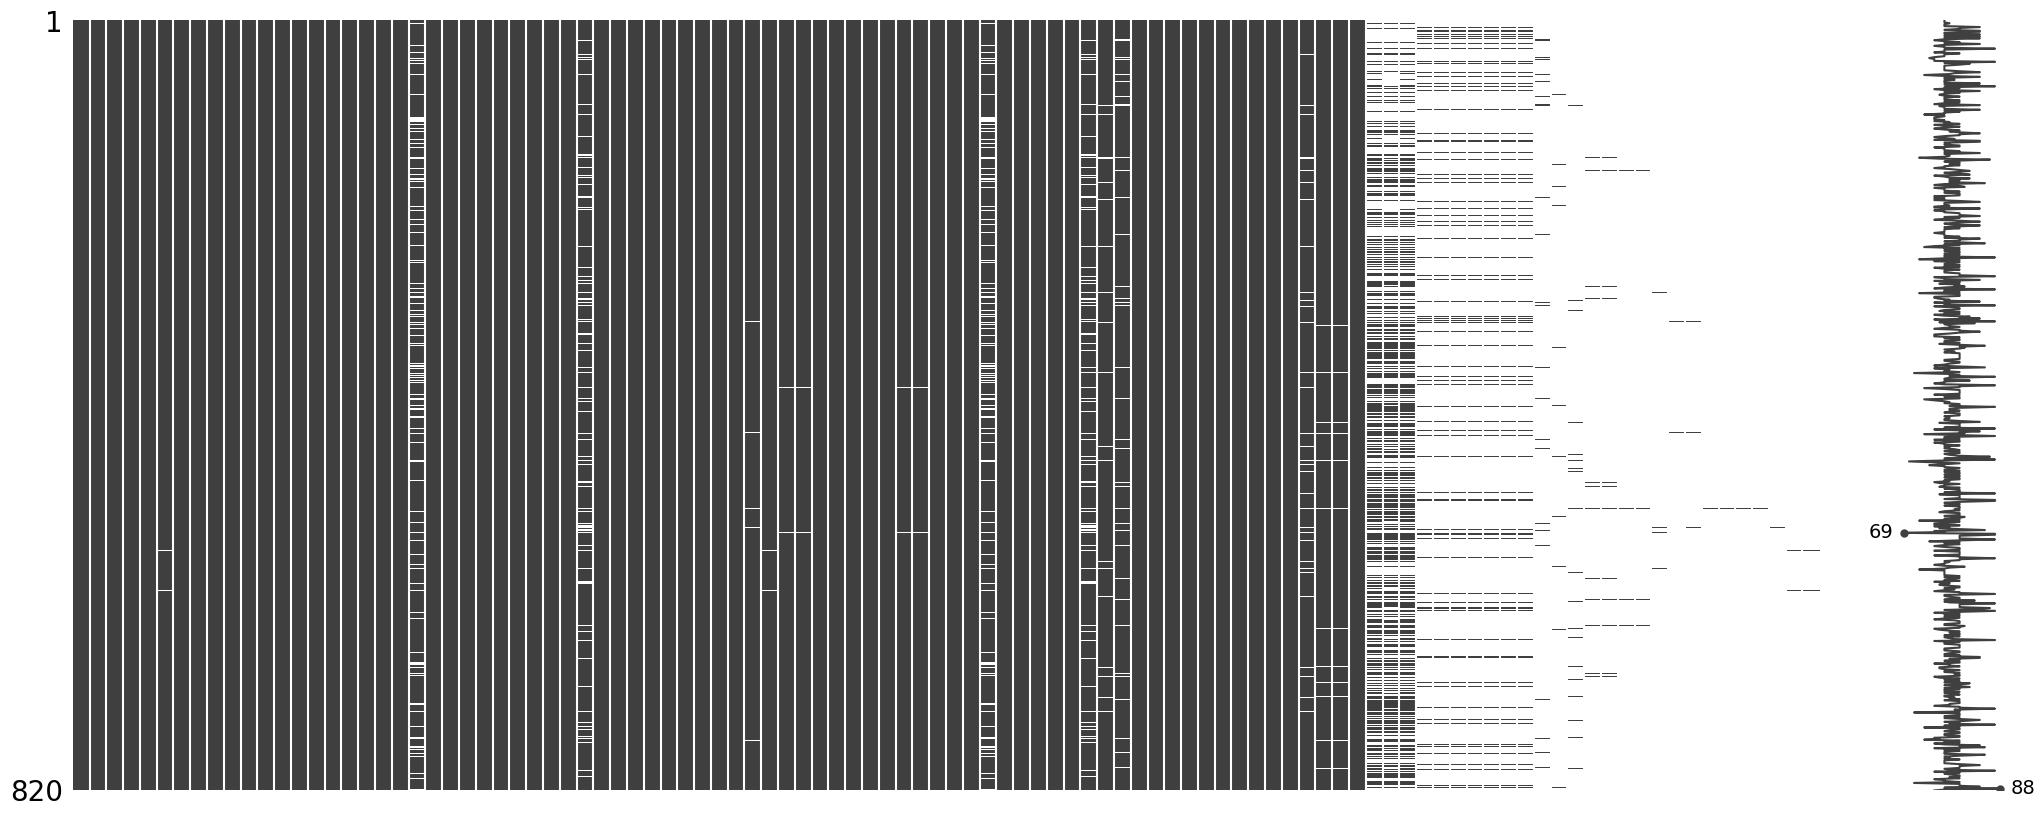

In [39]:
msno.matrix(df)


<Axes: >

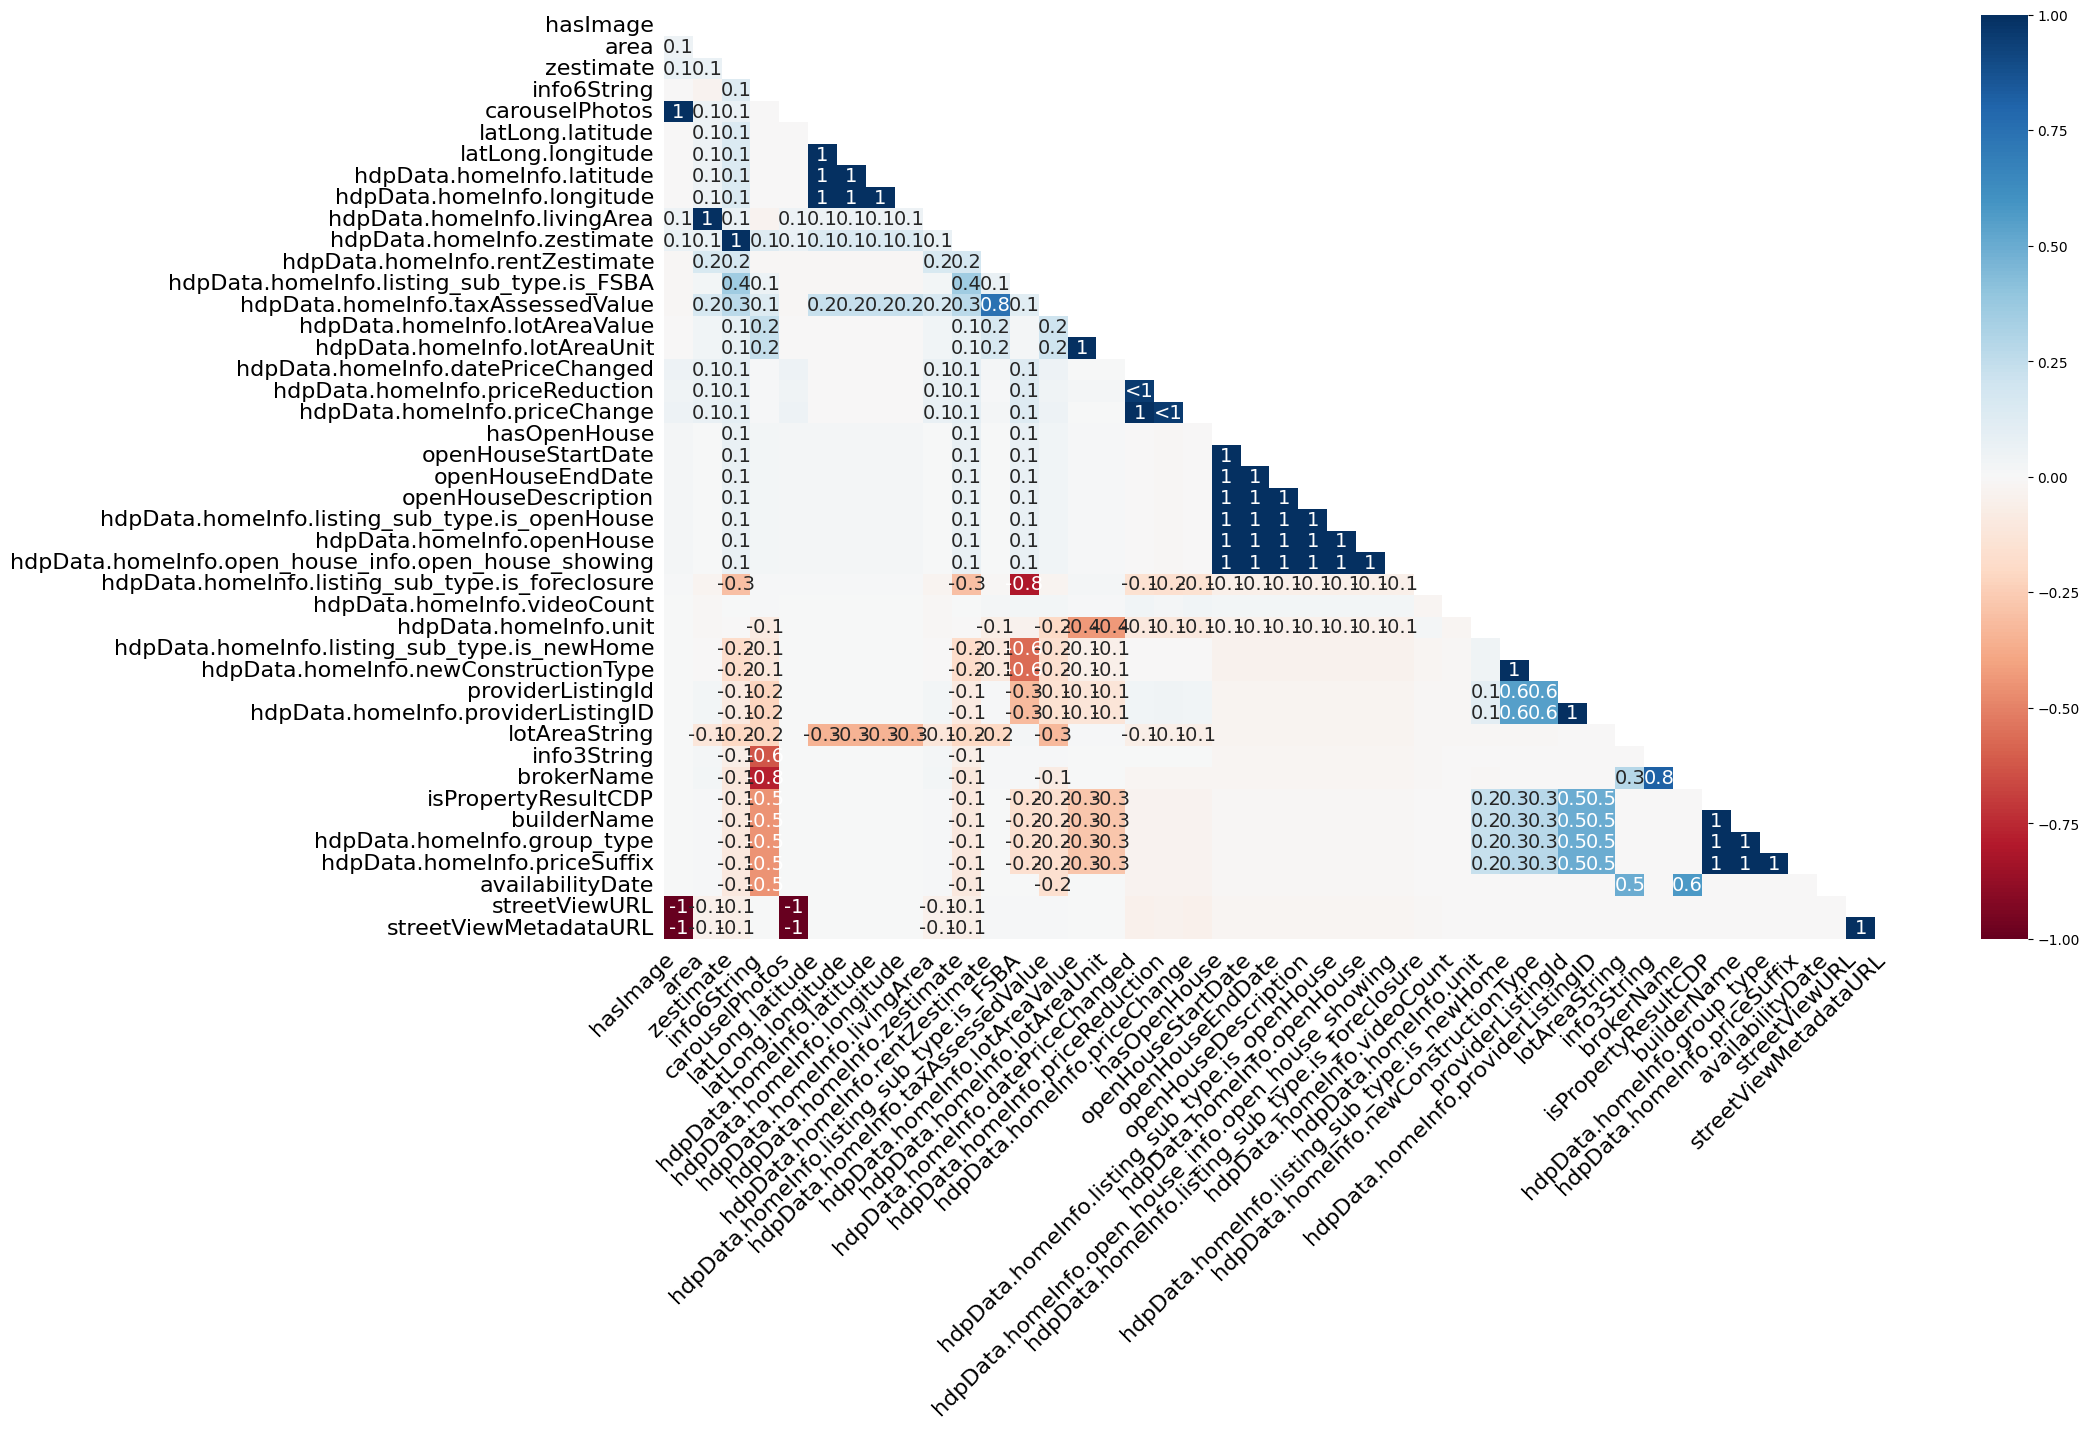

In [40]:
msno.heatmap(df)

In [42]:
ord_enc = sklearn.preprocessing.OrdinalEncoder()
df['statusCode'] = ord_enc.fit_transform(df[['statusText']])
df.head()

,zpid,id,rawHomeStatusCd,marketingStatusSimplifiedCd,imgSrc,hasImage,detailUrl,statusType,statusText,countryCurrency,...,info3String,brokerName,isPropertyResultCDP,builderName,hdpData.homeInfo.group_type,hdpData.homeInfo.priceSuffix,availabilityDate,streetViewURL,streetViewMetadataURL,statusCode
0,11648294,11648294,ForSale,For Sale by Agent,https://photos.zillowstatic.com/fp/2e49cf856fe...,True,https://www.zillow.com/homedetails/403-Antenor...,FOR_SALE,House for sale,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000
1,11523885,11523885,ForSale,For Sale by Agent,https://photos.zillowstatic.com/fp/f99f352dd93...,True,https://www.zillow.com/homedetails/124-Byron-R...,FOR_SALE,House for sale,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000
2,11322771,11322771,ForSale,For Sale by Agent,https://photos.zillowstatic.com/fp/2a0df563f18...,True,https://www.zillow.com/homedetails/126-S-Ohio-...,FOR_SALE,House for sale,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000
3,11600040,11600040,ForSale,For Sale by Agent,https://photos.zillowstatic.com/fp/0bda7cc963b...,True,https://www.zillow.com/homedetails/717-Greenle...,FOR_SALE,House for sale,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000
4,11641676,11641676,ForSale,For Sale by Agent,https://photos.zillowstatic.com/fp/54292b5e4cb...,True,https://www.zillow.com/homedetails/3833-Church...,FOR_SALE,House for sale,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000


In [ ]:
drop_cols = [
    #'zpid',
    'id',
    #'rawHomeStatusCd',
    #'marketingStatusSimplifiedCd',
    #'imgSrc',
    #'hasImage',
    #'detailUrl',
    #'statusType',
    #'statusText',
    #'countryCurrency',
    'price',
    #'unformattedPrice',
    # 'address',
    # 'addressStreet',
    # 'addressCity',
    # 'addressState',
    # 'addressZipcode',
    # 'isUndisclosedAddress',
    # 'beds',
    # 'baths',
    # 'area',
    # 'isZillowOwned',
    # 'flexFieldText',
    # 'flexFieldType',
    # 'contentType',
    # 'isSaved',
    # 'isUserClaimingOwner',
    # 'isUserConfirmedClaim',
    # 'pgapt',
    # 'sgapt',
    # 'zestimate',
    # 'shouldShowZestimateAsPrice',
    # 'has3DModel',
    # 'hasVideo',
    # 'isHomeRec',
    # 'hasAdditionalAttributions',
    # 'isFeaturedListing',
    # 'isShowcaseListing',
    # 'list',
    # 'relaxed',
    #'info6String',
    'carouselPhotos',
    #'latLong.latitude',
    #'latLong.longitude',
    'hdpData.homeInfo.zpid',
    'hdpData.homeInfo.streetAddress',
    'hdpData.homeInfo.zipcode',
    'hdpData.homeInfo.city',
    'hdpData.homeInfo.state',
    'hdpData.homeInfo.latitude',
    'hdpData.homeInfo.longitude',
    'hdpData.homeInfo.price',
    'hdpData.homeInfo.bathrooms',
    'hdpData.homeInfo.bedrooms',
    'hdpData.homeInfo.livingArea',
    #'hdpData.homeInfo.homeType',
    #'hdpData.homeInfo.homeStatus',
    #'hdpData.homeInfo.daysOnZillow',
    #'hdpData.homeInfo.isFeatured',
    #'hdpData.homeInfo.shouldHighlight',
    'hdpData.homeInfo.zestimate',
    #'hdpData.homeInfo.rentZestimate',
    #'hdpData.homeInfo.listing_sub_type.is_FSBA',
    #'hdpData.homeInfo.isUnmappable',
    #'hdpData.homeInfo.isPreforeclosureAuction',
    #'hdpData.homeInfo.homeStatusForHDP',
    #'hdpData.homeInfo.priceForHDP',
    #'hdpData.homeInfo.timeOnZillow',
    'hdpData.homeInfo.isNonOwnerOccupied',
    'hdpData.homeInfo.isPremierBuilder',
    'hdpData.homeInfo.isZillowOwned',
    'hdpData.homeInfo.currency',
    'hdpData.homeInfo.country',
    'hdpData.homeInfo.taxAssessedValue',
    #'hdpData.homeInfo.lotAreaValue',
    #'hdpData.homeInfo.lotAreaUnit',
    'hdpData.homeInfo.isShowcaseListing',
    #'hdpData.homeInfo.datePriceChanged',
    #'hdpData.homeInfo.priceReduction',
    #'hdpData.homeInfo.priceChange',
    'hasOpenHouse',
    'openHouseStartDate',
    'openHouseEndDate',
    'openHouseDescription',
    'hdpData.homeInfo.listing_sub_type.is_openHouse',
    'hdpData.homeInfo.openHouse',
    'hdpData.homeInfo.open_house_info.open_house_showing',
    'hdpData.homeInfo.listing_sub_type.is_foreclosure',
    'hdpData.homeInfo.videoCount',
    'hdpData.homeInfo.unit',
    'hdpData.homeInfo.listing_sub_type.is_newHome',
    'hdpData.homeInfo.newConstructionType',
    'providerListingId',
    'hdpData.homeInfo.providerListingID',
    'lotAreaString',
    'info3String',
    'brokerName',
    'isPropertyResultCDP',
    'builderName',
    'hdpData.homeInfo.group_type',
    'hdpData.homeInfo.priceSuffix',
    'availabilityDate',
    'streetViewURL',
    'streetViewMetadataURL',
    'statusCode'
 ]

array(['FOR_SALE'], dtype=object)

In [81]:
data2 = parse_to_pd('allegheny-county-pa/sold')


#### Finished successfully!

**Scraped all links**

Wrote **820** lines.

Selected UA: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36 Edg/130.0.0.0
Breaking: last_url == url.


In [82]:
data2.head()

,zpid,id,rawHomeStatusCd,marketingStatusSimplifiedCd,imgSrc,hasImage,detailUrl,statusType,statusText,countryCurrency,...,badgeInfo.text,hdpData.homeInfo.isRentalWithBasePrice,streetViewURL,streetViewMetadataURL,hdpData.homeInfo.datePriceChanged,hdpData.homeInfo.priceReduction,hdpData.homeInfo.priceChange,info3String,brokerName,hdpData.homeInfo.listing_sub_type.is_forAuction
0,11310305,11310305,RecentlySold,RecentChange,https://photos.zillowstatic.com/fp/e0782b7937b...,True,https://www.zillow.com/homedetails/400-Jonquil...,SOLD,Sold,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11275797,11275797,RecentlySold,RecentChange,https://photos.zillowstatic.com/fp/9baf7becb0a...,True,https://www.zillow.com/homedetails/1411-Simona...,SOLD,Sold,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11286695,11286695,RecentlySold,RecentChange,https://photos.zillowstatic.com/fp/2bc18234575...,True,https://www.zillow.com/homedetails/815-Industr...,SOLD,Sold,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11314065,11314065,RecentlySold,RecentChange,https://photos.zillowstatic.com/fp/8198914ebf4...,True,https://www.zillow.com/homedetails/1236-Raven-...,SOLD,Sold,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11363785,11363785,RecentlySold,RecentChange,https://photos.zillowstatic.com/fp/863c5f5cc4e...,True,https://www.zillow.com/homedetails/5711-King-O...,SOLD,Sold,$,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
